<a href="https://colab.research.google.com/github/chaulagai2001/Speech_for_timit_dataset/blob/main/Speech_timit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Move the uploaded Kaggle API key to the required directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace "your_dataset" with the Kaggle dataset username/dataset name
!kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

darpa-timit-acousticphonetic-continuous-speech.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q darpa-timit-acousticphonetic-continuous-speech.zip -d darpa-timit-acousticphonetic-continuous-speech

In [4]:
import librosa as lr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle as pk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.io.wavfile import write

In [5]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from collections import defaultdict

In [6]:
from keras.callbacks import EarlyStopping

# Load the raw audio recording

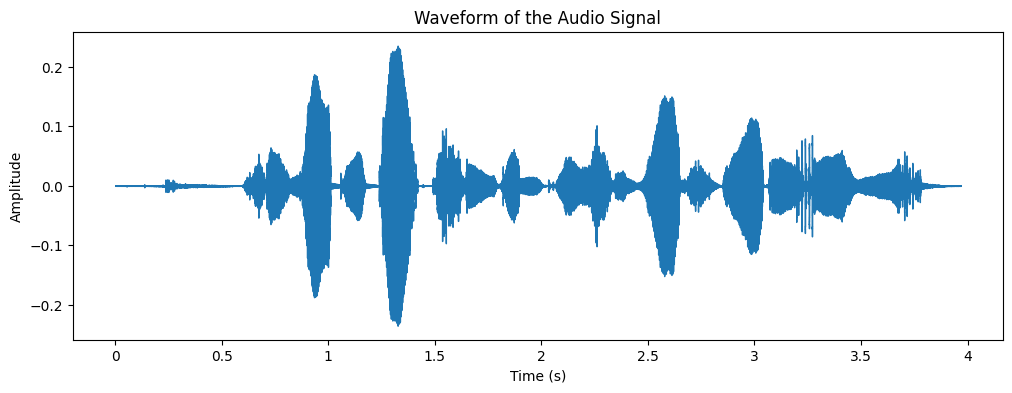

In [7]:
audio_file_path = '/content/darpa-timit-acousticphonetic-continuous-speech/data/TEST/DR1/FAKS0/SA1.WAV'

# Load the audio file
audio_signal, sampling_rate = lr.load(audio_file_path, sr=None)

# Display the audio signal waveform
plt.figure(figsize=(12, 4))
lr.display.waveshow(audio_signal, sr=sampling_rate)
plt.title('Waveform of the Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

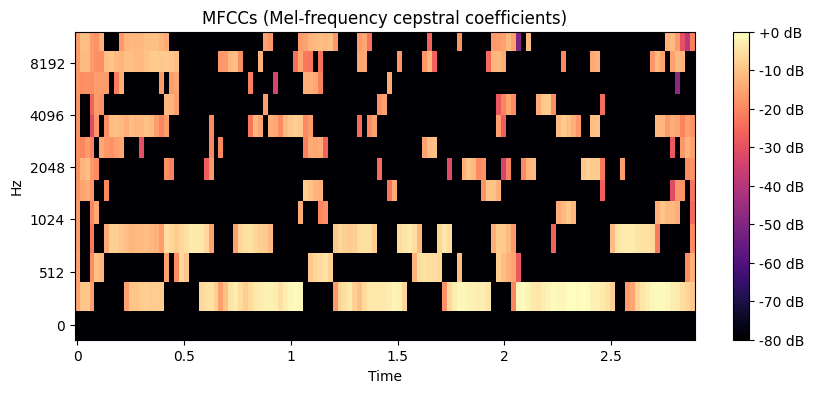

In [9]:
# Extract MFCCs
mfccs = lr.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=13)

# Display the MFCCs
plt.figure(figsize=(10, 4))
lr.display.specshow(lr.power_to_db(mfccs, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs (Mel-frequency cepstral coefficients)')
plt.show()

In [10]:
from IPython.display import Audio

# Play the audio
Audio(data=audio_signal, rate=sampling_rate)


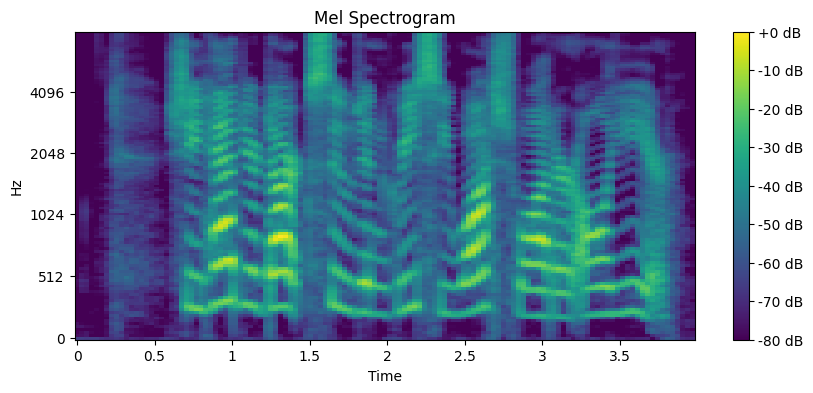

In [11]:
import librosa.display

# Compute the mel spectrogram
mel_spectrogram = lr.feature.melspectrogram(y=audio_signal, sr=sampling_rate, n_mels=128)

# Convert to decibels
mel_spectrogram_db = lr.power_to_db(mel_spectrogram, ref=np.max)

# Plot the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, y_axis='mel', x_axis='time', sr=sampling_rate, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


In [20]:
import os
import librosa
import pandas as pd

# Specify the path to the TIMIT dataset
timit_root_folder = '/content/darpa-timit-acousticphonetic-continuous-speech/data'

# Create a list to store data
audio_data = []

# Function to calculate audio file duration
def get_audio_duration(file_path):
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    duration = len(audio_signal) / sampling_rate
    return duration

# Traverse through all subdirectories and calculate duration for each audio file
for root, dirs, files in os.walk(timit_root_folder):
    for audio_file in files:
        if audio_file.endswith('.wav'):
            file_path = os.path.join(root, audio_file)
            duration = get_audio_duration(file_path)
            label = os.path.basename(root)
            audio_data.append({'AudioFile': file_path, 'Duration': duration, 'Label': label})

# Create a Pandas DataFrame from the list
timit_duration_df = pd.DataFrame(audio_data)

timit_duration_df



,AudioFile,Duration,Label
0,/content/darpa-timit-acousticphonetic-continuo...,3.372813,MKAM0
1,/content/darpa-timit-acousticphonetic-continuo...,2.892812,MKAM0
2,/content/darpa-timit-acousticphonetic-continuo...,4.409625,MKAM0
3,/content/darpa-timit-acousticphonetic-continuo...,2.496000,MKAM0
4,/content/darpa-timit-acousticphonetic-continuo...,2.828813,MKAM0
...,...,...,...
6295,/content/darpa-timit-acousticphonetic-continuo...,3.193625,MDLD0
6296,/content/darpa-timit-acousticphonetic-continuo...,2.572812,MDLD0
6297,/content/darpa-timit-acousticphonetic-continuo...,4.576000,MDLD0
6298,/content/darpa-timit-acousticphonetic-continuo...,2.220813,MDLD0


In [21]:
average_duration = timit_duration_df['Duration'].mean()

print(f'The average duration of audio files is: {average_duration:.2f} seconds')


The average duration of audio files is: 3.08 seconds


In [22]:
total_files = len(timit_duration_df)
files_with_duration_3_08 = len(timit_duration_df[timit_duration_df['Duration'] == 3.08])

print(f'Total number of files: {total_files}')
print(f'Number of files with a duration of 3.08 seconds: {files_with_duration_3_08}')


Total number of files: 6300
Number of files with a duration of 3.08 seconds: 0


In [27]:
import librosa
# Specify the path to the TIMIT dataset
timit_root_folder = '/content/darpa-timit-acousticphonetic-continuous-speech/data'

# Target duration for all audio files (in seconds)
target_duration = 3.0

# Function to load and pad/truncate audio files
def process_audio_file(file_path, target_duration):
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)

    # Calculate the current duration
    current_duration = len(audio_signal) / sampling_rate

    # Pad or truncate the audio to the target duration
    if current_duration < target_duration:
        # Pad with zeros if the audio is shorter than the target duration
        padding = np.zeros(int((target_duration - current_duration) * sampling_rate))
        audio_signal = np.concatenate((audio_signal, padding))
    elif current_duration > target_duration:
        # Truncate if the audio is longer than the target duration
        audio_signal = audio_signal[:int(target_duration * sampling_rate)]

    return audio_signal, sampling_rate

# Create a new directory to store processed audio files
processed_folder = '/content/Augmented_data'
os.makedirs(processed_folder, exist_ok=True)

# Process each audio file and save to the new directory
for root, dirs, files in os.walk(timit_root_folder):
    for audio_file in files:
        if audio_file.endswith('.wav'):
            file_path = os.path.join(root, audio_file)
            processed_audio, sr = process_audio_file(file_path, target_duration)

            # Save the processed audio to the new directory
            processed_file_path = os.path.join(processed_folder, audio_file)
            librosa.output.write_wav(processed_file_path, processed_audio, sr=sr)


            print(f'Saved processed file: {processed_file_path}')

print("All audio files processed and saved to:", processed_folder)



AttributeError: No librosa attribute output